## Notebook to define the Antarctic Circumpolar Current speed, based on the location of the slope front

In this notebook I will define the ASC speed, according the the location of the Antarctic Slope Front. The methodology will follow the follwoing steps.

## Part 1 - Defining the calculation domain
1st -  Define the northern limit for assessment. This limit will be the 2000m isobath, as it seems to be reasonably north of the ASC (check image below). Any U,V point north of the 2500m isobath will be masked out

<div>
<img src=http://localhost:8889/files/x77_wf4500/ASC_project/Screenshot.png?_xsrf=2%7C8efcce90%7Ccfbed000a96778f130e11d12f7bf853e%7C1682470238?_xsrf=2%7Ce7642a83%7C0a11d886fe09ceefb7d81a25d09d5077%7C1683074692 width="800"/>
</div>



In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import os
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import pylab
import cosima_cookbook as cc
session = cc.database.create_session()
from dask.distributed import Client
client = Client(n_workers=28)
client

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR)

Importing U,V and the bathymetry, and make any appropriate means or averages

In [2]:
#Getting variables
#variable = 'uvel'
experiment = '01deg_jra55v13_ryf9091'
UVEL = cc.querying.getvar(experiment, 'u' , session, frequency='1 monthly', n=-40)
UVEL = UVEL.isel({'yu_ocean': slice(0, 494)})#.isel({'st_ocean': slice(0, 40)})# First 500 m
VVEL = cc.querying.getvar(experiment, 'v' , session, frequency='1 monthly',n=-40)
VVEL = VVEL.isel({'yu_ocean': slice(0, 494)})#.isel({'st_ocean': slice(0, 40)})
dzt = cc.querying.getvar(experiment, 'dzt' , session, frequency='1 monthly',n=-40)
dzt = dzt.isel({'yt_ocean': slice(0, 494)})#.isel({'st_ocean': slice(0, 40)})
# To minimize computational efforts you can....
      # Set ylim to get only the Southermost Latitudes of the Southern Ocean (Lets say south of 60S)
      # Set a depth limit too.. perhaps 1000m or 500 m
      #When I calculate the mean it has to be a weighted mean against dzt
#Load the bathymetry
hu = cc.querying.getvar(experiment, 'hu', session, n=1).drop(['geolat_c', 'geolon_c']).isel({'yu_ocean': slice(0, 494)})

# Calculating yearly mean of U,V
VVELmean = VVEL.groupby('time.year').mean('time').mean('year')
UVELmean = UVEL.groupby('time.year').mean('time').mean('year')
dztmean = dzt.groupby('time.year').mean('time').mean('year')

#Regridding them
import xgcm
print("xgcm version ", xgcm.__version__)
folder = '/scratch/v45/wf4500/simulations/01deg_jra55_ryf_zmin21m/wf4500/access-om2/archive/ryf/output000/ocean/'
grid = xr.open_mfdataset(folder+'ocean_grid.nc', combine='by_coords').isel({'yu_ocean': slice(0, 494)}).isel({'yt_ocean': slice(0, 494)})

ds = xr.merge([UVELmean,VVELmean,dztmean, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
grid = xgcm.Grid(ds, periodic=['X','Y'])

#Weighted mean Along Z
UVELmeanz = ((grid.interp(UVELmean,['X','Y'])*dztmean).sum('st_ocean'))/dztmean.sum('st_ocean')
VVELmeanz = ((grid.interp(VVELmean,['X','Y'])*dztmean).sum('st_ocean'))/dztmean.sum('st_ocean')



xgcm version  0.8.1


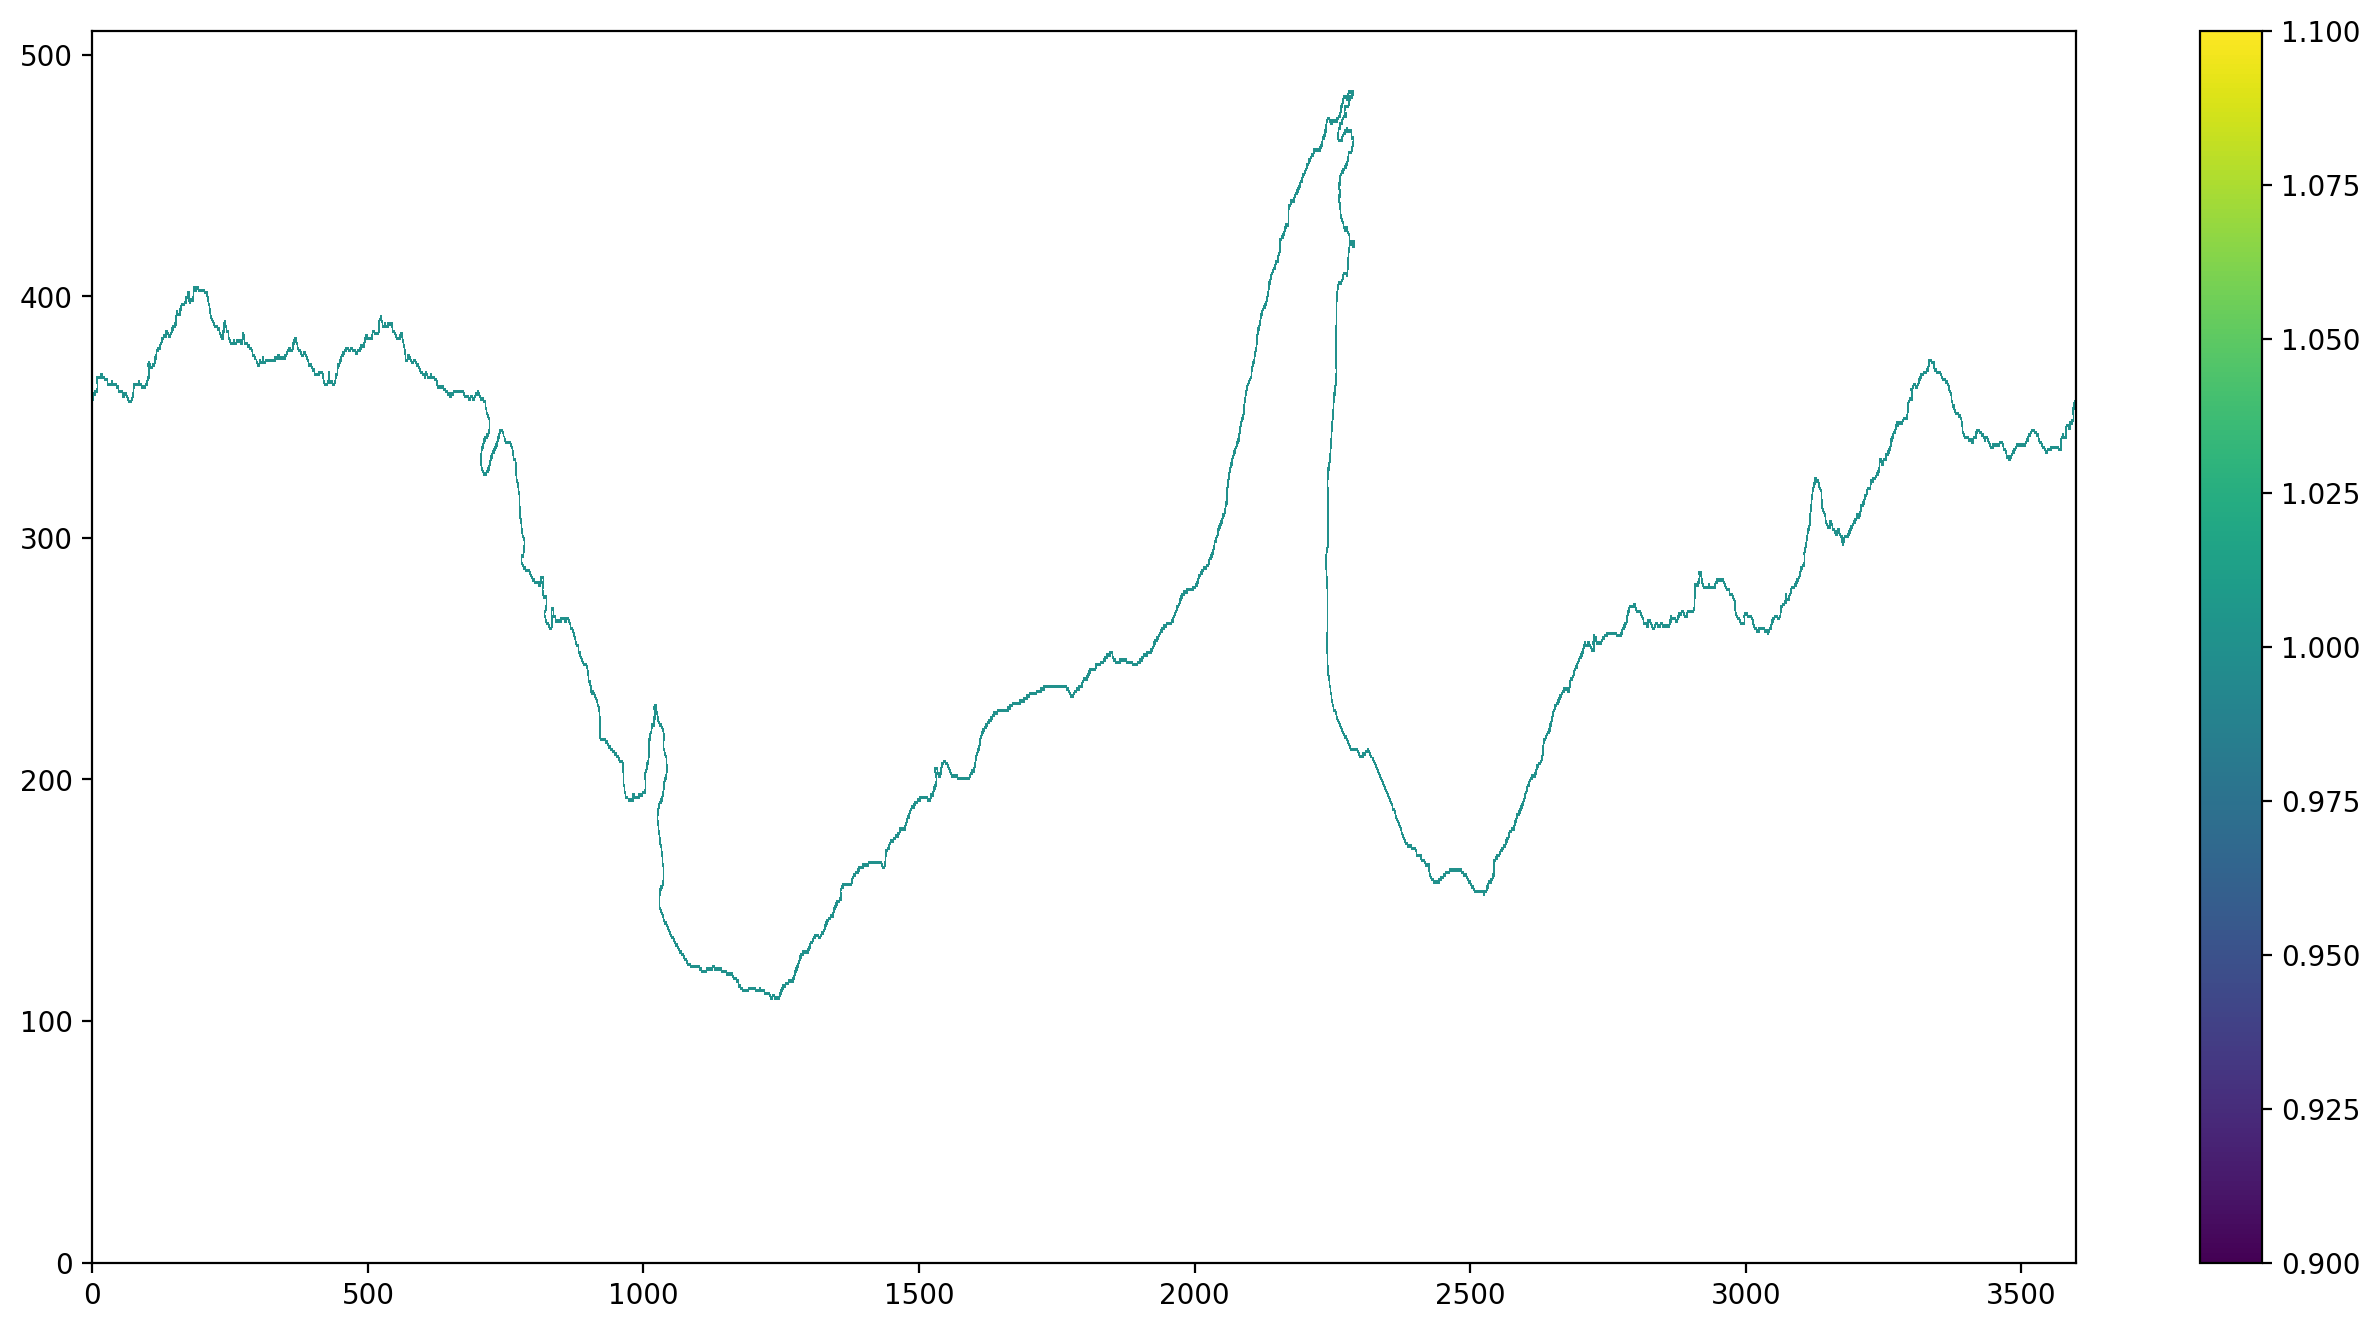

In [3]:
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_1000m.npz'
data = np.load(outfile)
data
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
isobath100m =(mask_x_transport+mask_y_transport)
fig = plt.figure(figsize = (16, 8))
isobath100m = isobath100m/isobath100m
plt.pcolor(isobath100m)
plt.colorbar()

#we have the line that we want. now we need to
#turn that contour line into 2 1d coords. lets try

In [4]:
isobath100m2 = np.nan_to_num(isobath100m,nan=100)
isobath100m2=isobath100m2[0:494,:]
isobath100mline=np.reshape(isobath100m2,(1,494*3600))
np.where(isobath100mline == 1)
test = isobath100mline[np.where(((isobath100mline <1) | (isobath100mline >100)) & ((isobath100mline >1) & (isobath100mline <100)))]
#Ok we only have 1s and 100s now in out matrix


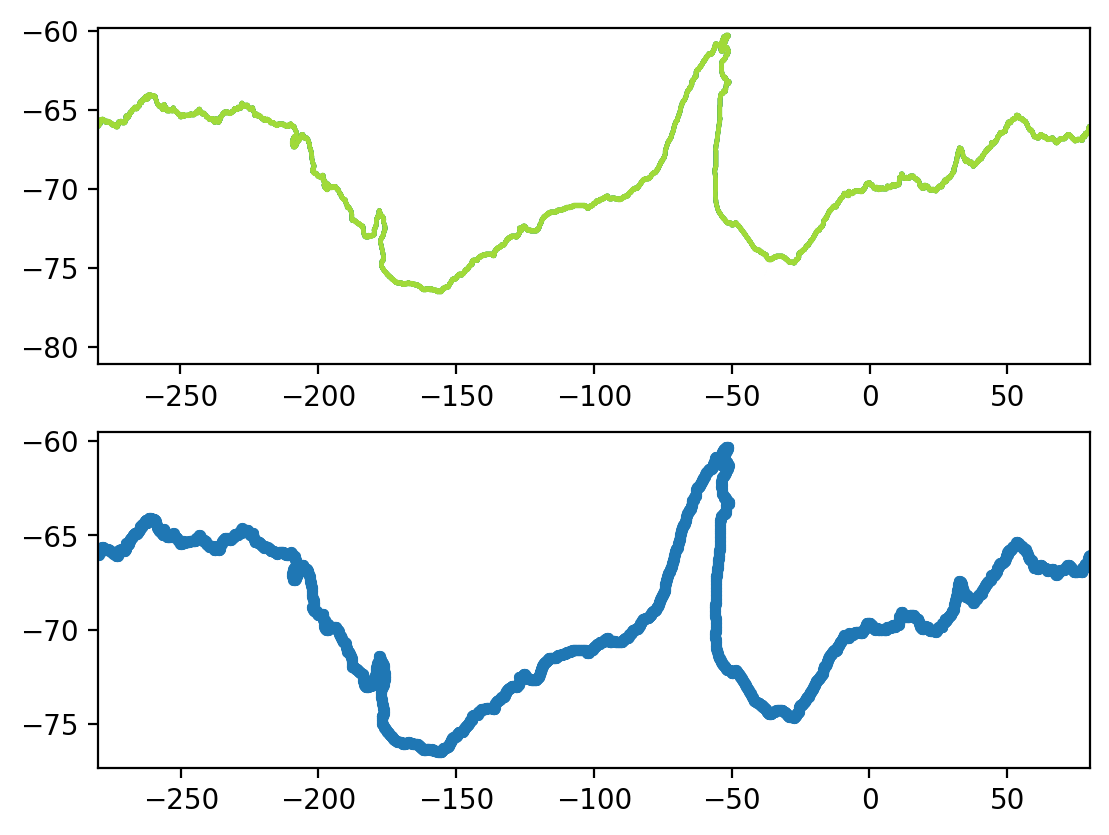

In [5]:
x_=VVELmeanz['xt_ocean']
y_=VVELmeanz['yt_ocean']
plt.subplot(211)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
cs =plt.contour(x_,y_,isobath100m2)
#plt.colorbar()
plt.subplot(212)
test = np.array(np.where(isobath100m2.T== 1))
np.shape(test)
plt.plot(x_[test[0,:]],y_[test[1,:]],'.')
plt.xlim(-280,80)
# It seems that we got the right indexes.
xlon_1000miso=x_[test[0,:]]
xlat_1000miso=y_[test[1,:]]

In [6]:
# #Getting the isobath
bath = xr.open_dataset('/home/156/wf4500/access-om2-01/ryf/archive/output000/ocean/ocean_grid.nc')
bath=bath.ht
lat_range = slice(-90, -56)
# select one year and latitude range
bath_mean = bath.sel(yt_ocean = lat_range)

h = bath_mean.load()


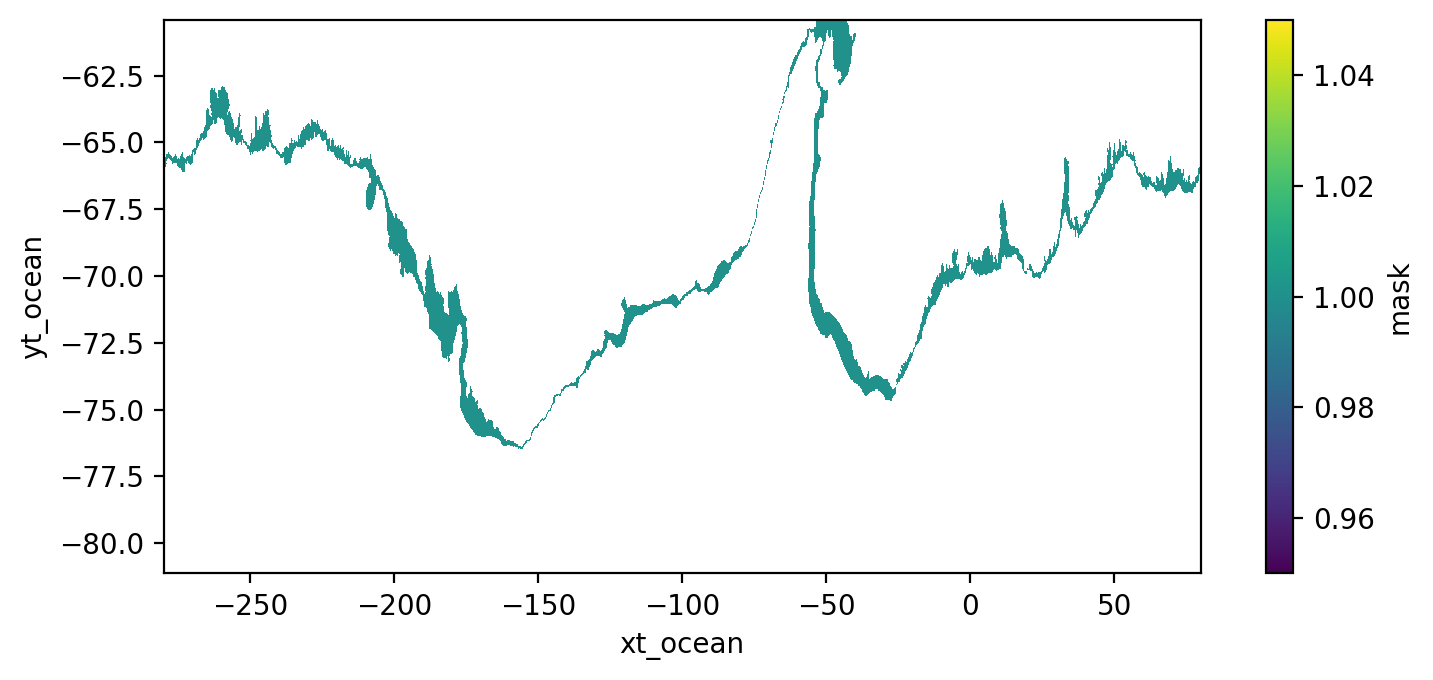

In [7]:
mask_88mto2500m=xr.open_dataset('/g/data/v45/wf4500/mask_88mto2500m.nc')
mask_88mto2500m  = mask_88mto2500m.rename(__xarray_dataarray_variable__='mask')
mask_88mto2500m.mask.plot()
isobath = mask_88mto2500m.mask

In [8]:
#Applying the mask to UVel
UVELmeanzm2 =  UVELmeanz + isobath - isobath #Applying the mask

In [10]:
%%time
# Calculating the speed
V = np.sqrt(np.square(UVELmeanzm2) + np.square(VVELmeanz)).compute()

Text(0.5, 1.0, 'Speed field under  to 2500m] isobath')

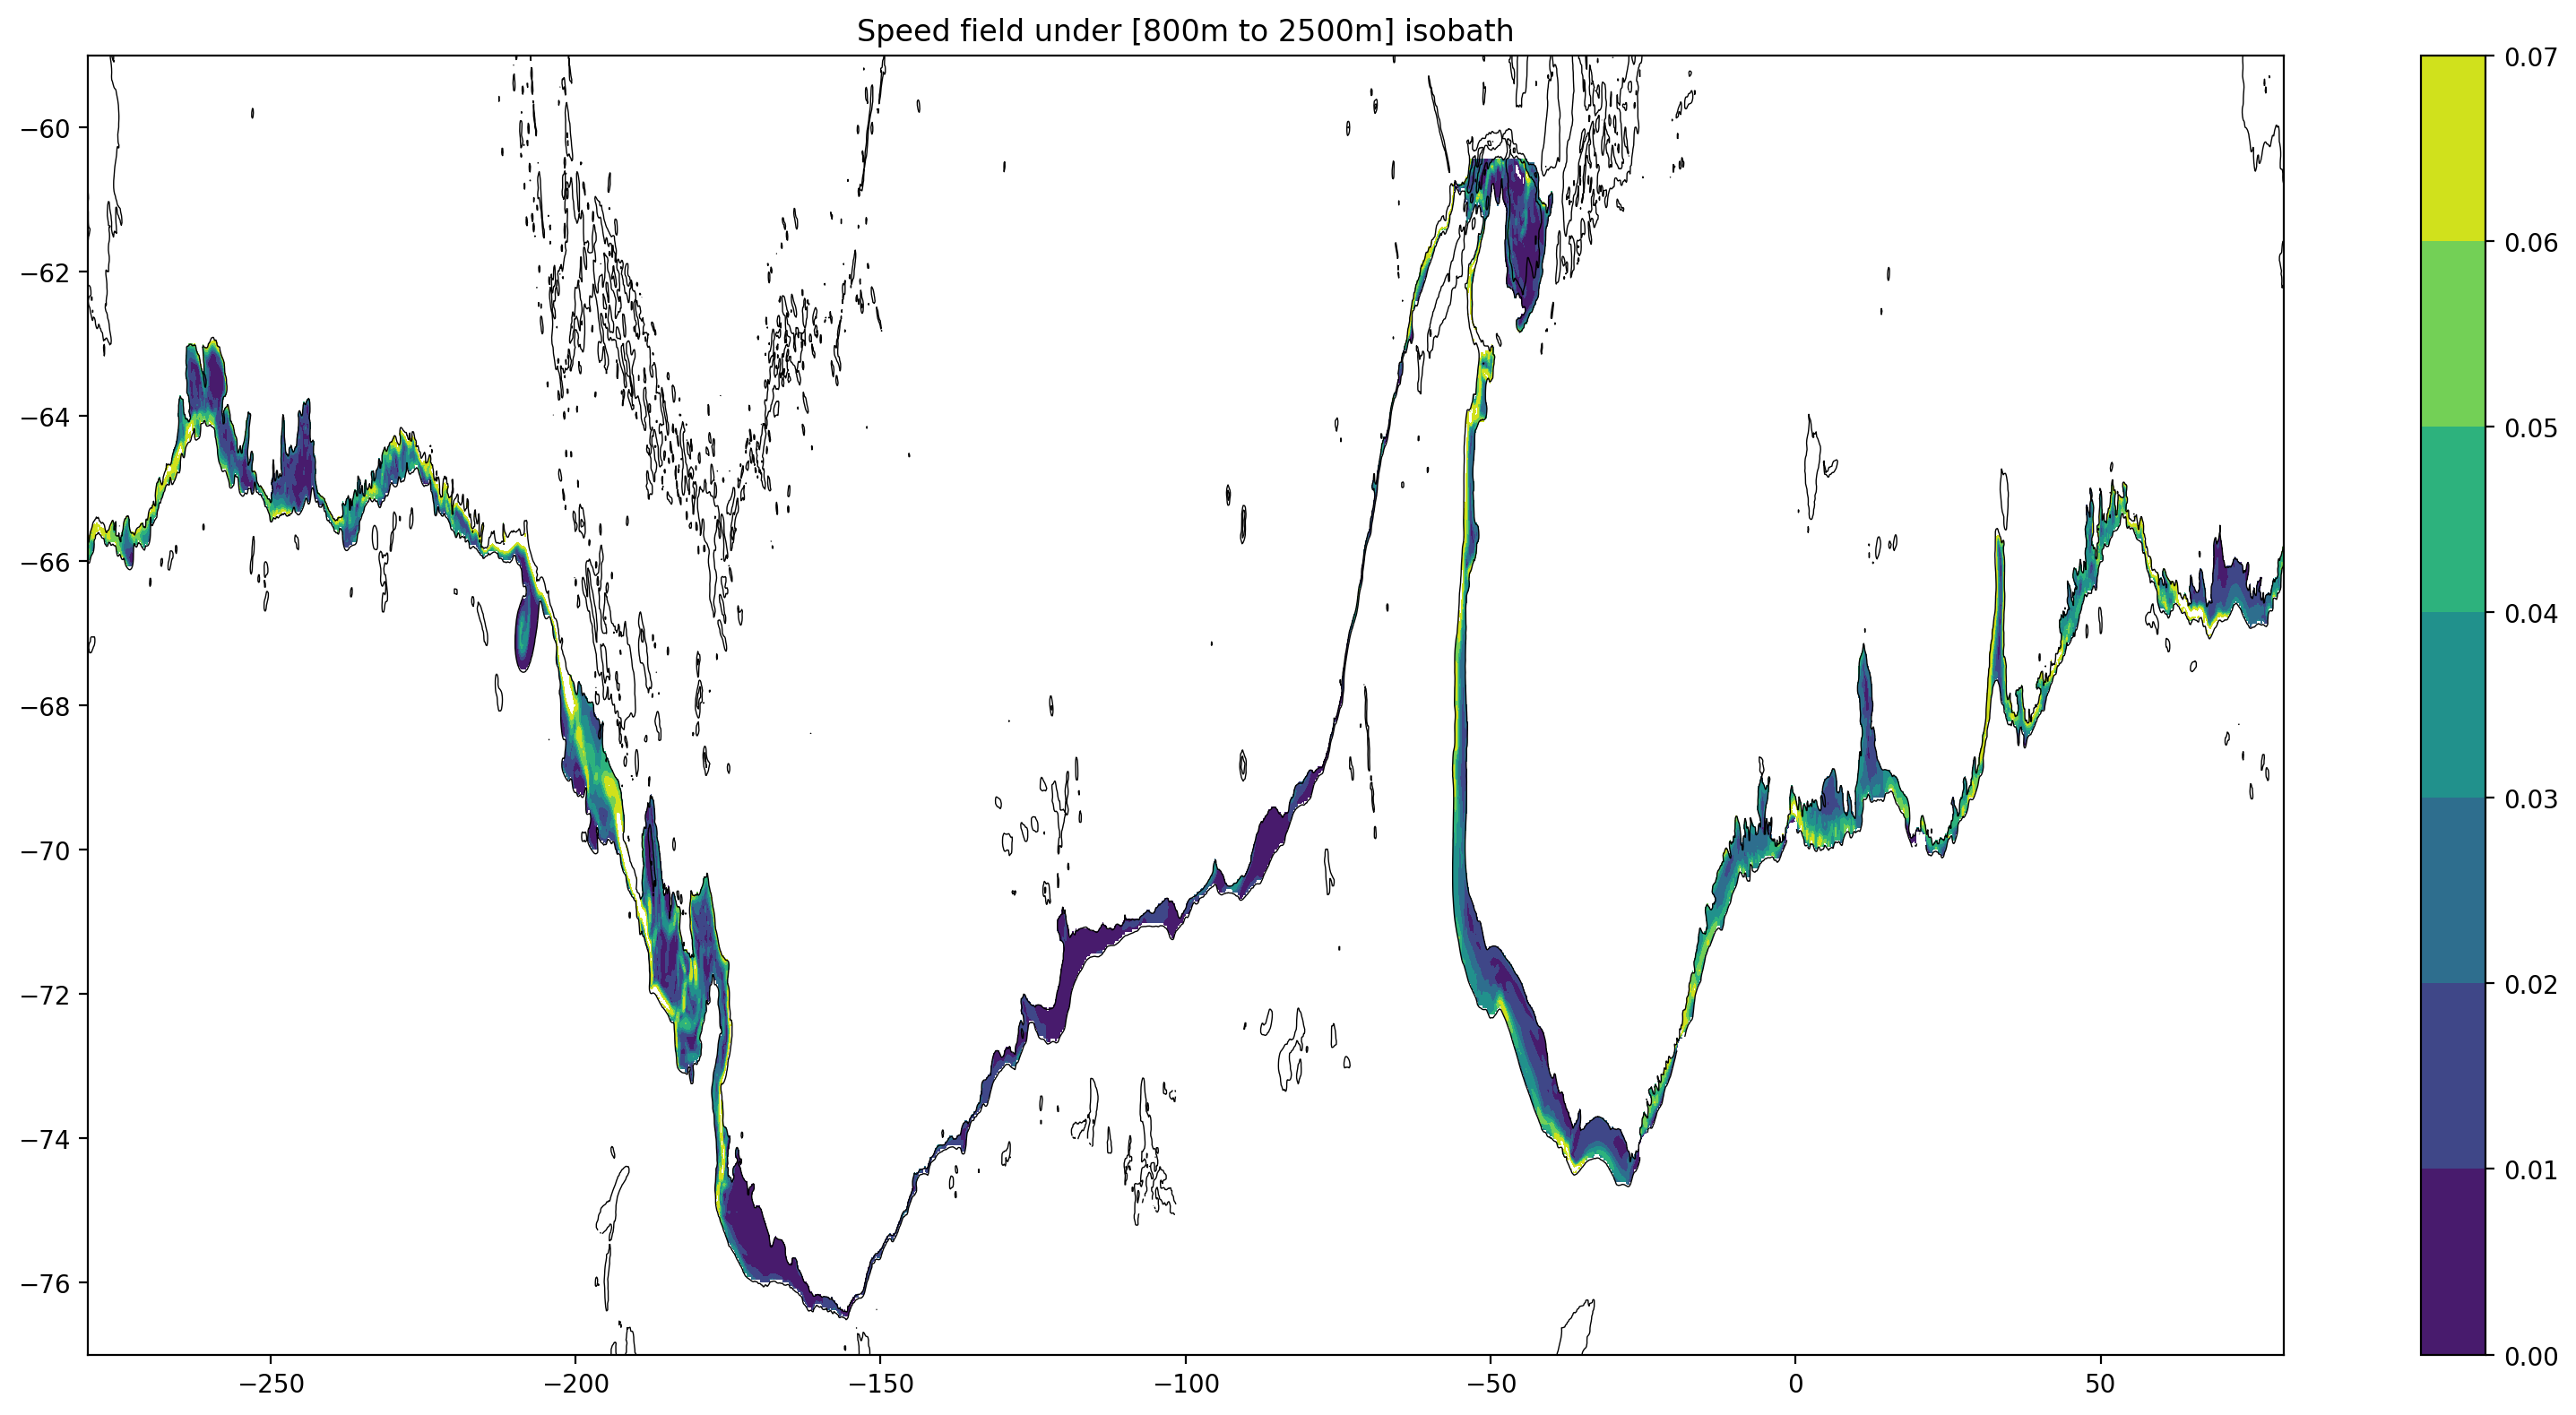

In [11]:
# Checking the mask over the Uvels ... it seems correct
fig = plt.figure(figsize = (16, 8))
plt.contourf(V.xt_ocean,V.yt_ocean,V,np.arange(0,0.07,0.01))
plt.colorbar()
sc = plt.contour(h.xt_ocean,h.yt_ocean,h, levels=[800,2500],colors='k',linewidths=0.5)
plt.ylim(-77,-59)
plt.title('Speed field under [800m to 2500m] isobath')

## Getting the UV Components along the Shelf

I will need to transpose the data. First then I need to find in the angle the slope has with the longitude. This angle would be use for the coordinate rotation. I Can set this angle as the direction of the 800 m contour.

In [12]:
#Step 1 - checkin gif taht is a appropriate line.

l800m = xr.open_dataset('/g/data/v45/wf4500/reverse800misobath_mask_clean.nc')
l800m = l800m.rename(__xarray_dataarray_variable__='mask')

l1000m = xr.open_dataset('/g/data/v45/wf4500/1000isobath_mask_clean.nc')
l1000m = l1000m.rename(__xarray_dataarray_variable__='mask')


In [279]:
# #Defining first non_nan yindex function
# def firstNonNan(listfloats):
#     import math
#     for item in np.arange(0,np.size(listfloats)):
#         if math.isnan(listfloats[item]) == False:
#             return item

In [280]:
#GEtting the first non_nan for all longitude lines
# GEtting the first non nan along lats dont work because AP is no only along longitude lines
# #first case:
# line8000m = firstNonNan(np.array(l800m.mask.isel(dim_1=0))) #separating an array for that specific longitude
# line1000m = np.flip(firstNonNan(np.array(l1000m.mask.isel(dim_1=0)))) #separating an array for that specific longitude
# #remainin cases
# for n in range(1,3600):
#     t2 = np.array(l800m.mask.isel(dim_1=n)) #separating an array for that specific longitude
#     line8000m = np.append(line8000m,firstNonNan(t2))
#     t3 = np.flip(np.array(l1000m.mask.isel(dim_1=n))) #separating an array for that specific longitude
#     line1000m = np.append(line1000m,firstNonNan(t3))
# line1000m=-line1000m+566    
# np.shape(line1000m)

(3600,)

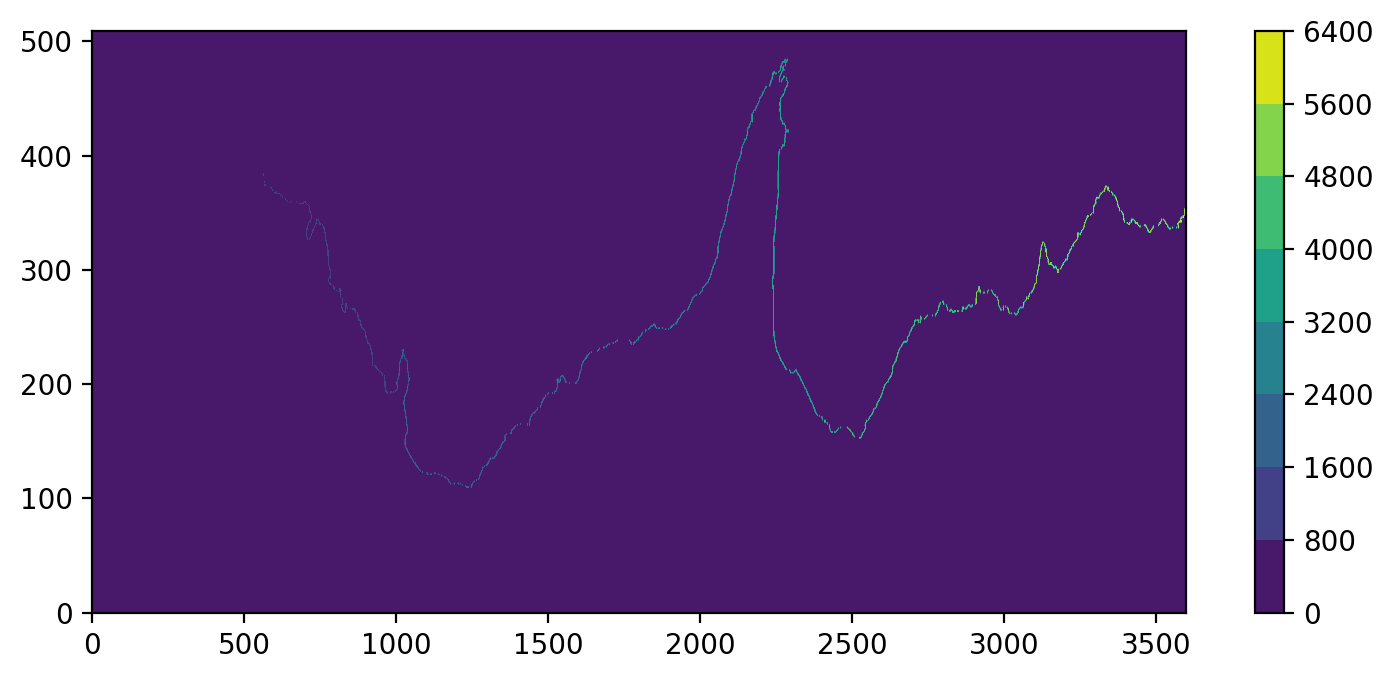

In [290]:
#lonlats=xr.open_dataset('/g/data/v45/wf4500/lon_lats_1000miso.nc')
#lonlats=np.array(lonlats.__xarray_dataarray_variable__)
#np.shape(lonlats)
plt.contourf(mask_x_transport_numbered)
plt.colorbar()

In [225]:
yt_ocean = cc.querying.getvar(experiment, 'yt_ocean' , session, frequency='1 monthly', n=-1)
yt_ocean=yt_ocean.isel(yt_ocean=slice(0,510))
xt_ocean = cc.querying.getvar(experiment, 'xt_ocean' , session, frequency='1 monthly', n=-1)
yu_ocean = cc.querying.getvar(experiment, 'yu_ocean' , session, frequency='1 monthly', n=-1)
xu_ocean = cc.querying.getvar(experiment, 'xu_ocean' , session, frequency='1 monthly', n=-1)

mask_x_transport_numbered =xr.DataArray(data['mask_x_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xt_ocean)}).rename(dim_0="yt_ocean",dim_1="xt_ocean")
mask_y_transport_numbered =xr.DataArray(data['mask_y_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean),"dim_1": np.array(xt_ocean)}).rename(dim_0="yt_ocean",dim_1="xt_ocean")
num_points = int(np.maximum(np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))
num_points

6002

In [230]:
lat_along_contour = np.zeros((num_points))
lon_along_contour = np.zeros((num_points))

# locations for zonal transport:
x_indices_masked = mask_x_transport_numbered.stack().values
x_indices = np.sort(x_indices_masked[x_indices_masked>0])
for count in x_indices:
    count = int(count)
    jj = int(np.where(mask_x_transport_numbered==count)[0])
    ii = int(np.where(mask_x_transport_numbered==count)[1])   
    lon_along_contour[count-1] = xt_ocean[ii].values
    lat_along_contour[count-1] = mask_x_transport_numbered.yt_ocean[jj].values
    
# locations for meridional transport:
y_indices_masked = mask_y_transport_numbered.stack().values
y_indices = np.sort(y_indices_masked[y_indices_masked>0])
for count in y_indices:
    count = int(count)
    jj = np.where(mask_y_transport_numbered==count)[0]
    ii = np.where(mask_y_transport_numbered==count)[1]
    lon_along_contour[count-1] = mask_x_transport_numbered.xt_ocean[ii].values
    lat_along_contour[count-1] = yt_ocean[jj].values

In [237]:
lonlats=np.array([lon_along_contour,lat_along_contour])
np.shape(lonlats)

(2, 6002)

In [239]:
#Check, is the line correct? It seems so. Option to zpoom to the beggining there to see if the angles are correct
#yt_ocean = V['yt_ocean']
#yline8000m = ylat_1000miso2
#plt.plot(lonlats[0,:],lonlats[1,:])
xline=lonlats[0,:]
yline=lonlats[1,:]
xlineind_=xt_ocean
ylineind_=yt_ocean
xlineind=np.where(xlineind_==xline[0])
ylineind=np.where(ylineind_==yline[0])
for n in range(1,6002):
    ax=np.where(xlineind_==xline[n])
    ay=np.where(ylineind_==yline[n])
    xlineind=np.append(xlineind,ax)
    ylineind=np.append(ylineind,ay)
    
#lonlats[0,:]
#ylineind=lonlats[1,:]
np.shape(xlineind),n
Vline=np.concatenate((V,V*np.nan),axis=0)
# Vline=Vline[:484,:]
Vline = Vline[ylineind,xlineind]



#plt.plot(xlon_1000miso2,ylat_1000miso2,'*')
# xline=V['xt_ocean']
# yline=yline8000m
#plt.xlim(-60,-30)
# plt.ylim(yline8000m[0]-0.1,yline8000m[10]+0.1)

Next to make the transformation I need to get the engle between the horizontal and the 800m slope line. For the I am gonna get the angle between the horizon and the slope indexes for every consecutive 2 points starting on indexes 0, 1 and 2. The three angle matrices will be averaged out to get a smooth edge. lets do it

I want to get the angle of the tangent exatly at each longitude point. This will be more consistent with the direction in which the current goes. So first I need to interpolate the data to the halfway point.

In [117]:
xline2=np.append(xline[3598]-360,np.append(xline,xline[0:3]+360))
yline2=np.append(yline[3598],np.append(yline,yline[0:3]))

#getting the midpoints that we want
#deltax = (xline[1]-xline[0])/2
#xline3=np.arange(xline2[0],xline2[3603],deltax)
xline3=(xline2[0]+xline2[0+1])/2
for n in range(1,3602):
    a=(xline2[n]+xline2[n+1])/2
    xline3=np.append(xline3,a)
    
#Smooth interpolation of data into the mid points
import scipy.interpolate as interpolate
f = interpolate.interp1d(xline2,yline2,kind='slinear')
yline3 = f(xline3)
plt.plot(xline3,yline3,label='interpolated line')
plt.plot(xline3,yline3,'*',label='interpolated line')
plt.plot(xline,yline,label='original line')
plt.plot(xline,yline,'*',label='original line')
plt.xlim(xline2[0]-0.1,xline2[10])
plt.ylim(yline2[0]-0.1,yline2[10]+0.1)
plt.legend()

In [118]:
#Next... getting the angle for every 3 points cycle
#first case
# I need to expand the lines by reeating the first few values into the end
#xline2=np.append(xline,xline[0:3])
#yline2=np.append(yline,yline[0:3])
n=0
Fd= 2 #distance of pointe used to calculate the angle
x0=xline3[(n):((n+Fd))]
x1=xline3[((n) +1):((n+1+Fd))]
x2=xline3[((n) +2):((n+2+Fd))]
y0=yline3[(n):((n+Fd))]
y1=yline3[((n)+1):((n+1+Fd))]
y2=yline3[((n)+2):((n+2+Fd))]
angle0 = np.rad2deg(np.arctan2(y0[-1] - y0[0], x0[-1] - x0[0]))
angle1 = np.rad2deg(np.arctan2(y1[-1] - y1[0], x1[-1] - x1[0]))
angle2 = np.rad2deg(np.arctan2(y2[-1] - y2[0], x2[-1] - x2[0]))
for n in range(1,3600):
    x0=xline3[(n):((n+Fd))]
    x1=xline3[((n) +1):((n+1+Fd))]
    x2=xline3[((n) +2):((n+2+Fd))]
    y0=yline3[(n):((n+Fd))]
    y1=yline3[((n)+1):((n+1+Fd))]
    y2=yline3[((n)+2):((n+2+Fd))]
    
    t0 = np.rad2deg(np.arctan2(y0[-1] - y0[0], x0[-1] - x0[0]))
    t1 = np.rad2deg(np.arctan2(y1[-1] - y1[0], x1[-1] - x1[0]))
    t2 = np.rad2deg(np.arctan2(y2[-1] - y2[0], x2[-1] - x2[0]))
    angle0=np.append(angle0,t0)
    angle1=np.append(angle1,t1)
    angle2=np.append(angle2,t2)
    
anglei_iso = (angle0+angle1)/2

In [145]:
xline3real=xline
yanglereal=angle0[0:3599]


In [ ]:
#minimum angle resolution
xdeg=0.1
ydeg=0.0422393
hyp=np.sqrt((ydeg*ydeg) + (xdeg*xdeg))

np.rad2deg(np.arcsin(ydeg/hyp))
#ok, the angle will be constrained by teh resolution. 
#perhaps I will find better resilts If I can find an average isother between 800, 1000m and 1500m. lets try.

22.898855554118292

(-66.0, -65.0)

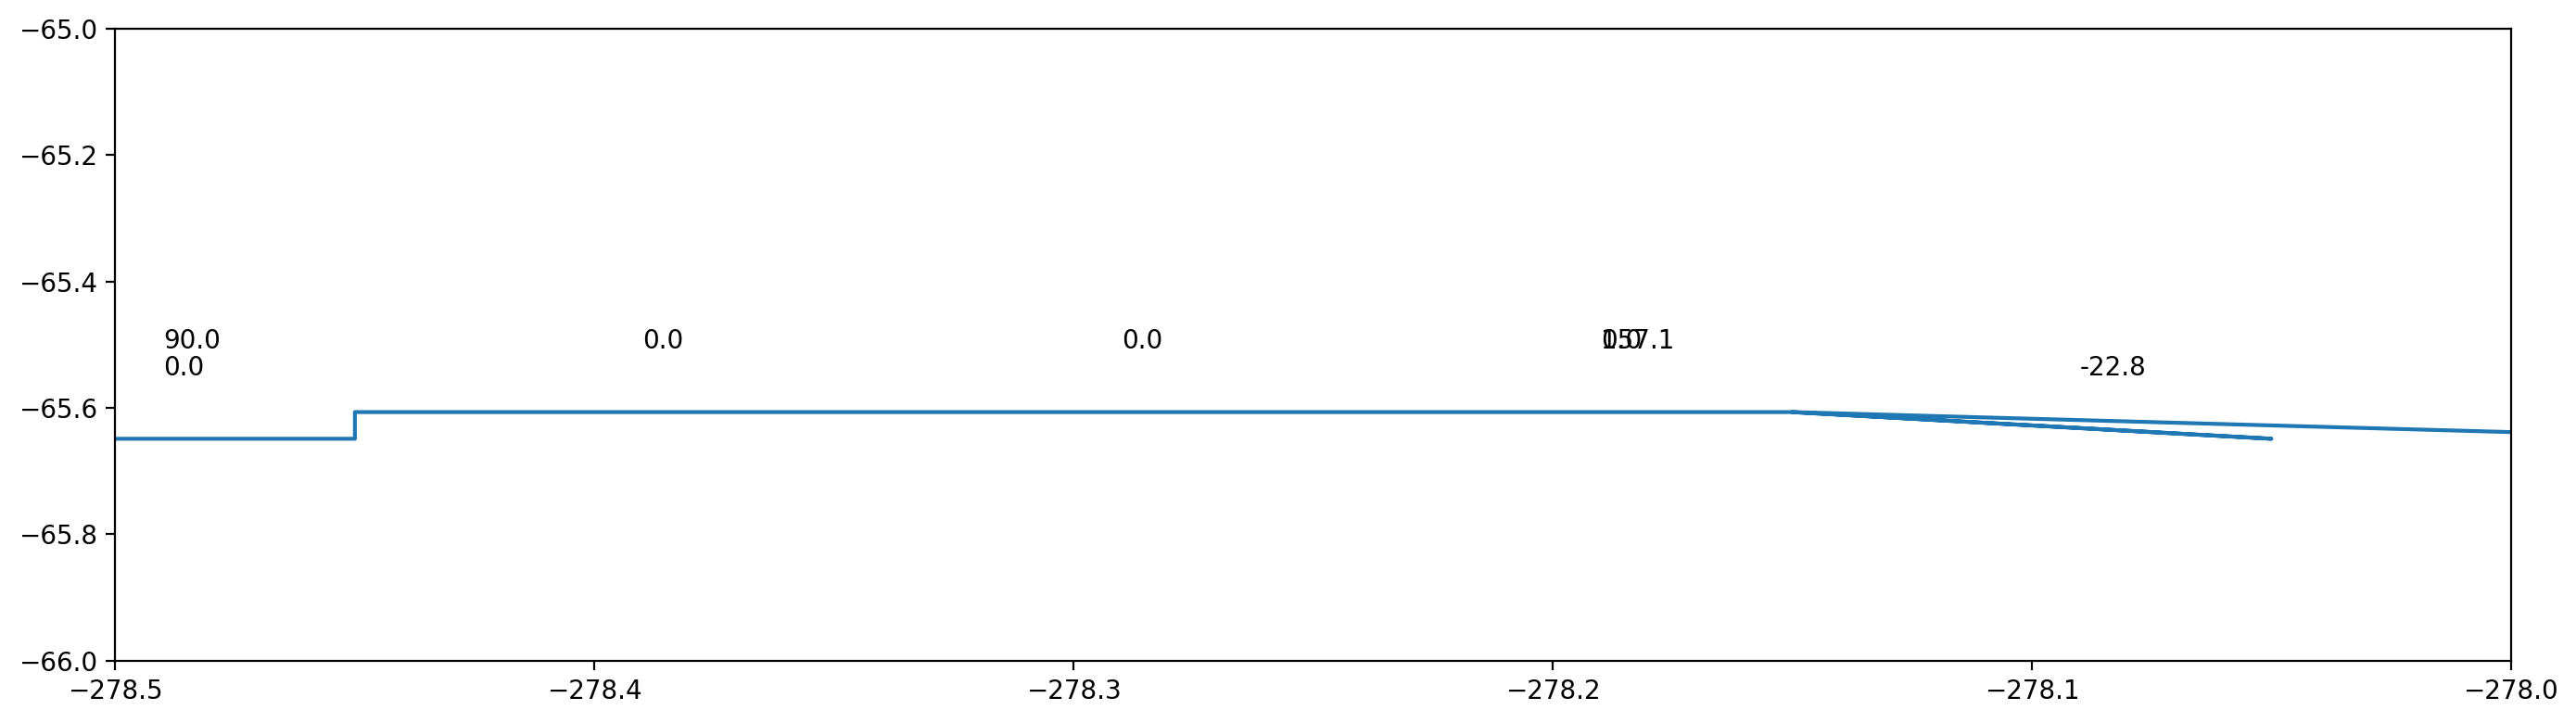

In [153]:
# I need to test if these angles make sense. lets make some plots at specific places
#plt.plot(anglei_iso)
fig = plt.figure(figsize = (14, 4))
uplimitoplot=20
lowlimitoplot=0
plt.plot(xline,yline8000m,label='800m isobath')
plt.plot(xline,yline8000m,'*',label='800m isobath')
plt.plot(xline3,yline3,label='Current direction')

#plt.plot(xline,yline8000m)
for n in range(lowlimitoplot,uplimitoplot):
    plt.text(xline[n]-0.04,yline8000m[n]+0.1,str(str(int(angle0[n]*10)/10)),clip_on=True)
             
plt.xlim(xline[lowlimitoplot]-0.1,xline[uplimitoplot])
plt.ylim(np.min(yline8000m[lowlimitoplot:uplimitoplot])-0.2,
         np.max(yline8000m[lowlimitoplot:uplimitoplot])+0.7)
plt.title('Degree values plotted over contour')
lowlimitoplot]xline[uplimitoplot]plt.legend()
#Ok, I checked out and this approach seem to work but  the angle measurement 
#seem to be always be somewhat binned by the fact the the grid is discrete.
#This leads the angle to always be a multiple of 11.9, which is the minimum angle between two
#adjacent points ( other than o)

## Distribution of speed along the slope

How does the integrated speed is distributed along the shelf? lets see and example for -278 W

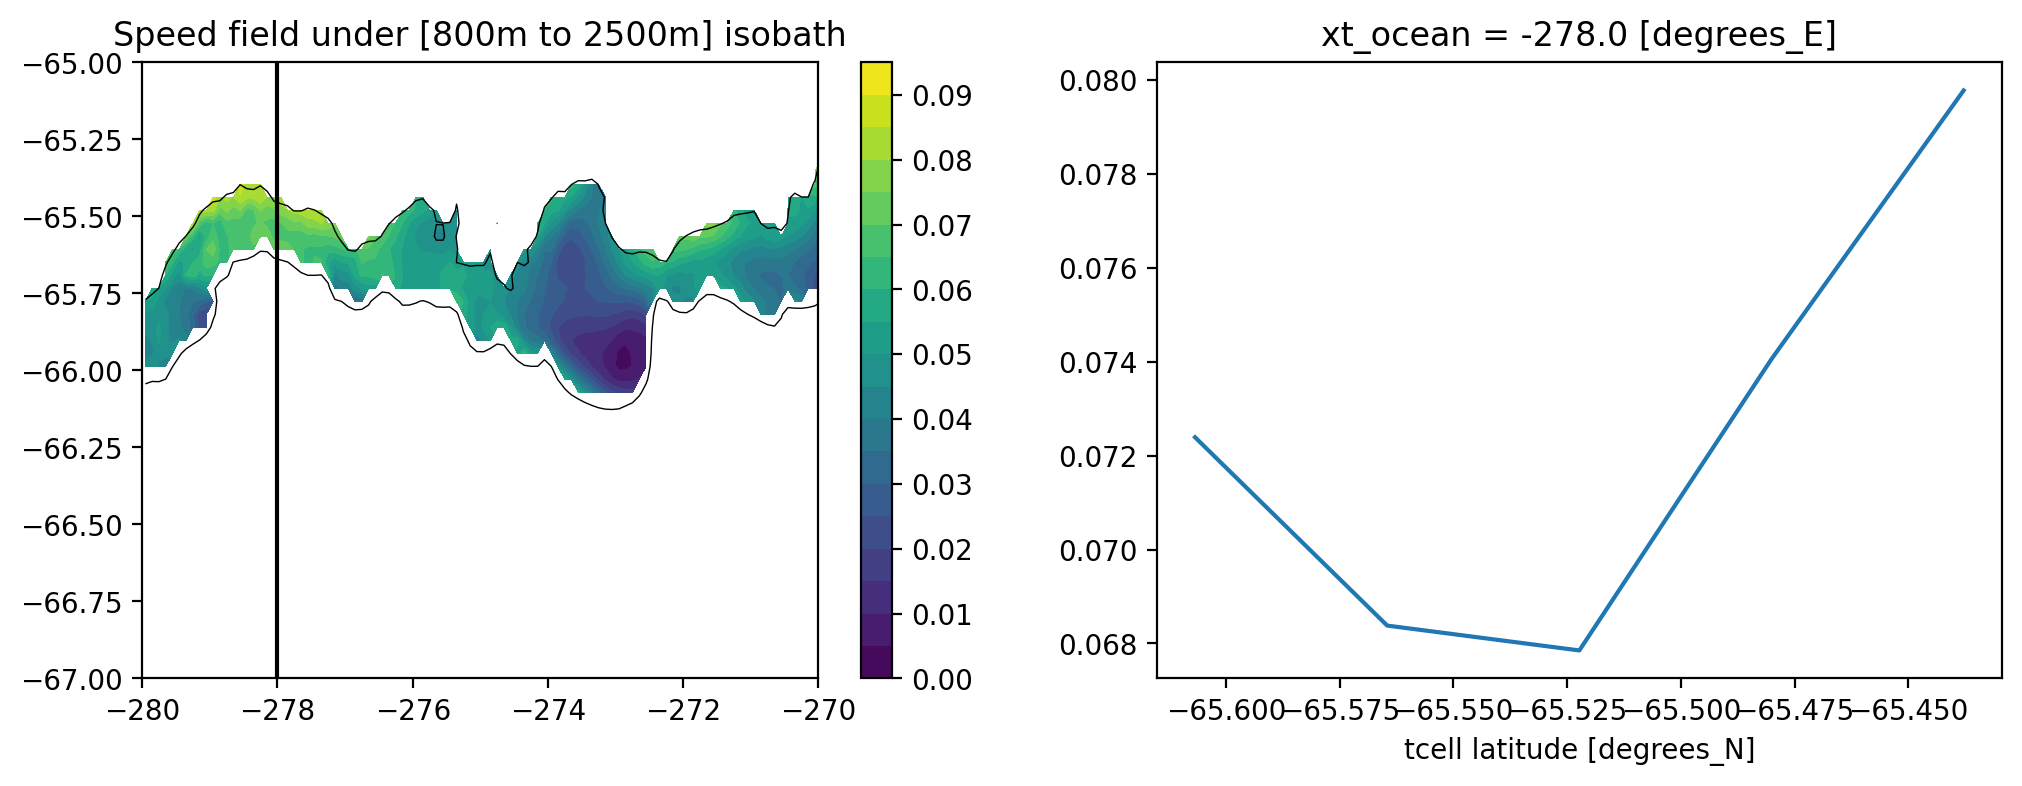

In [98]:
fig = plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.contourf(V.xt_ocean,V.yt_ocean,V,np.arange(0,0.1,0.005))
plt.plot([-278,-278],[-67,-65],color='k')
plt.colorbar()
sc = plt.contour(h.xt_ocean,h.yt_ocean,h, levels=[800,2500],colors='k',linewidths=0.5)
plt.ylim(-67,-65)
plt.xlim(-280,-270)
plt.title('Speed field under [800m to 2500m] isobath')

plt.subplot(122)
V.isel(xt_ocean=19).plot()

As you can see in this location the slope increases northward, so is a good test

## Plotting stereographic map of V
Instead, let's plot the same data with cartopy. This example uses the `Robinson` global projection -- but note that key argument in the plot function: `transform=ccrs.PlateCarree()` -- which is needed every time you plot something with cartopy. (Confusingly, you could also use a `PlateCarree` projection, not to be confused with the transformation ...)

In [71]:
# projection = ccrs.SouthPolarStereo()

# import matplotlib.path as mpath
# import cartopy.feature as cft

# land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
#                                    edgecolor='black', facecolor='papayawhip', linewidth=0.5)

# plt.figure(figsize=(6, 5))
# ax = plt.axes(projection=projection)

# ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree())
# ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
# ax.coastlines(resolution='50m')
# ax.gridlines(draw_labels=True,ylocs=[-65,-60],xlocs=[125,115])

# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)
# ax.set_boundary(circle, transform=ax.transAxes)

# V.plot(x='xt_ocean', y='yt_ocean',
#          transform=ccrs.PlateCarree(),
#          vmin=0, vmax=.02, extend='both',
#          cmap=cm.cm.speed,
#          cbar_kwargs = {'label': '|V|',
#                         'fraction': 0.03,
#                         'aspect': 15,
#                         'shrink': 0.7});

By the plot above, I think we might need ti use a even deeper isobath. See for example, in the eastern WEDDELL SEA THE CONTOUR IS JUST TOO THIN.

In [38]:
UVELmeanz2a = UVELmeanzm2.sel({'xt_ocean': slice(-246, -237)}).mean('xt_ocean')#.compute()
UVELmeanz2a = UVELmeanz2a#.compute()
humean=hu.sel({'xu_ocean': slice(-246, -237)}).mean('xu_ocean').compute()

Lets take a look at some small regions of interest (Totten and Amery)

Text(0.5, 1.0, 'Totten Ice Shelf')

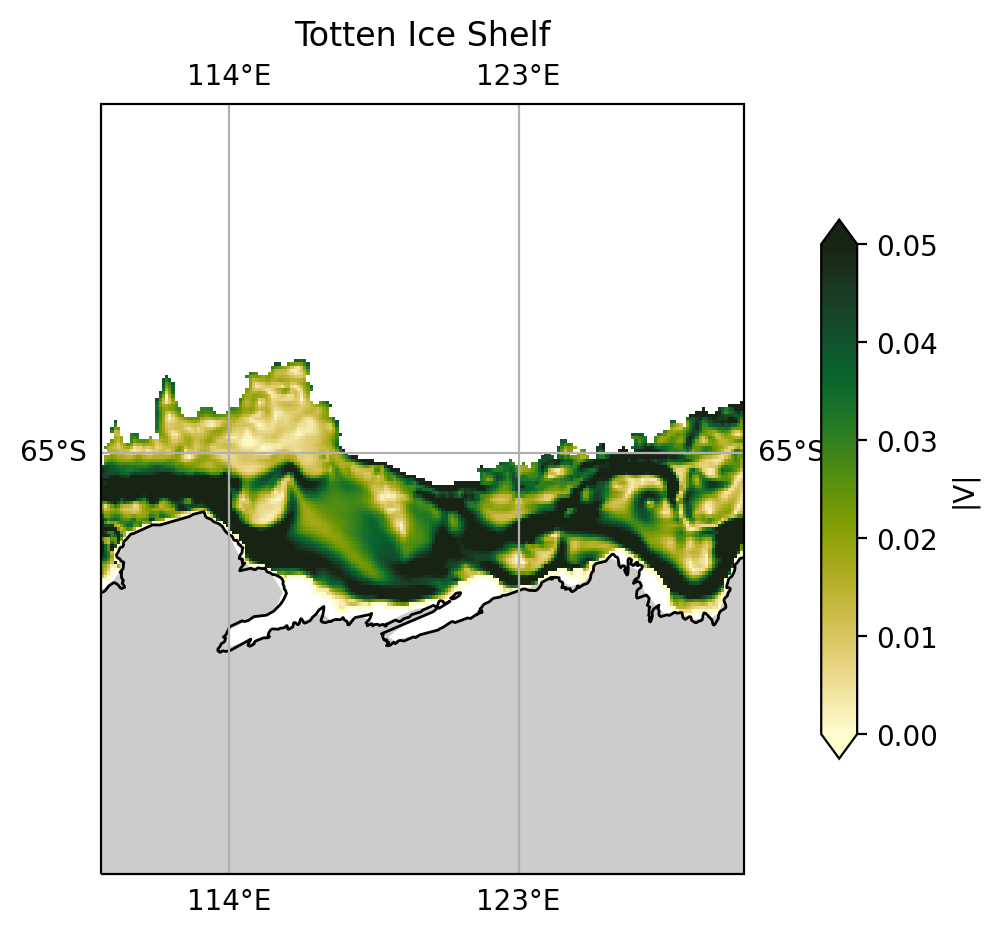

In [41]:
projection = ccrs.Mercator(central_longitude=120, min_latitude=-80.0, max_latitude=-55)

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=projection)

ax.set_extent([110, 130, -70, -60], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True,ylocs=[-65],xlocs=[123,114])
V.speed.plot(x='xt_ocean', y='yt_ocean',
         transform=ccrs.PlateCarree(),
         vmin=0, vmax=.05, extend='both',
         cmap=cm.cm.speed,
         cbar_kwargs = {'label': '|V|',
                        'fraction': 0.03,
                        'aspect': 15,
                        'shrink': 0.7});
plt.title('Totten Ice Shelf')

In [19]:
# #maximum negative speed seem to be ~67S. but South of 64S, all zonal speed seems negative (ASC)

# fig, ax1 = plt.subplots()
# #ax2 = ax1.twinx()
# #Batrhymetry
# ax1.plot(UVELmeanz2a['yt_ocean'], UVELmeanz2a, 'b-')
# ax1.plot(UVELmeanz2a['yt_ocean'].sel(yt_ocean=-65.46, method='nearest'), UVELmeanz2a.sel(yt_ocean=-65.46, method='nearest'), 'k*')
# ax1.set_xlabel('Latitude')
# ax1.grid()
# #Uvel
# #ax2.plot(UVELmeanz2['yt_ocean'],UVELmeanz2, 'g-')
# #ax2.grid()


# ax1.set_ylabel('Bathymetry [m]', color='b')
# plt.title('Totten Ice Shelf')

Text(0.5, 1.0, 'Amery Ice Shelf')

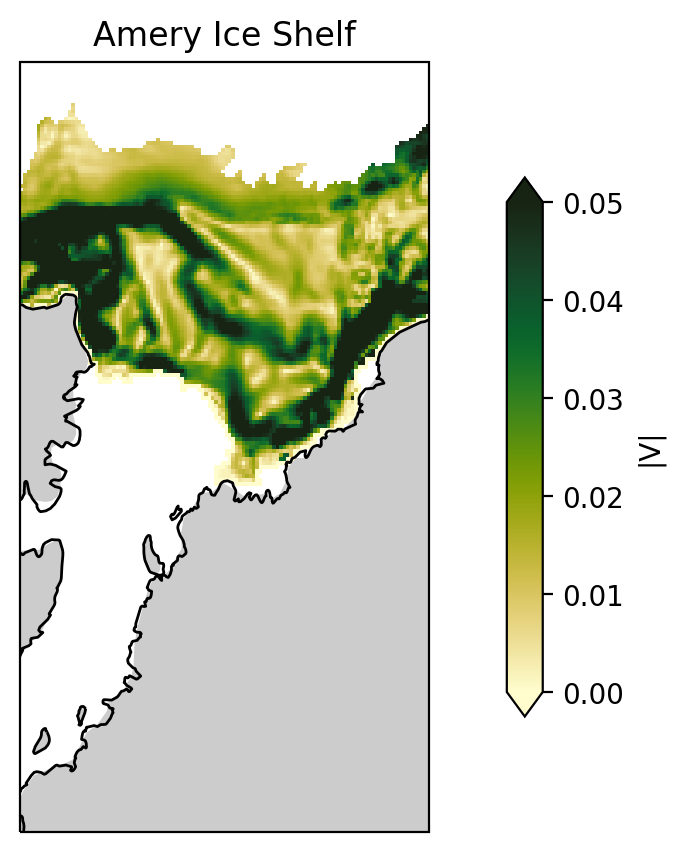

In [43]:
projection = ccrs.Mercator(central_longitude=72, min_latitude=-80.0, max_latitude=-55)

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=projection)

ax.set_extent([80, 68, -73, -65], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True,ylocs=[-65],xlocs=[123,114])
V.speed.plot(x='xt_ocean', y='yt_ocean',
         transform=ccrs.PlateCarree(),
         vmin=0, vmax=.05, extend='both',
         cmap=cm.cm.speed,
         cbar_kwargs = {'label': '|V|',
                        'fraction': 0.03,
                        'aspect': 15,
                        'shrink': 0.7});
plt.title('Amery Ice Shelf')

In [44]:
UVELmeanza = UVELmeanz.sel({'xt_ocean': slice(68, 80)}).mean('xt_ocean')#.compute()
UVELmeanza = UVELmeanza#.compute()
humeana=hu.sel({'xu_ocean': slice(68, 80)}).mean('xu_ocean').compute()

In [23]:
# #maximum negative speed seem to be ~67S. but South of 64S, all zonal speed seems negative (ASC)

# fig, ax1 = plt.subplots()
# #ax2 = ax1.twinx()
# #Batrhymetry
# ax1.plot(UVELmeanza['yt_ocean'], UVELmeanza, 'b-')
# ax1.plot(UVELmeanza['yt_ocean'].sel(yt_ocean=-66.77, method='nearest'), UVELmeanza.sel(yt_ocean=-66.77, method='nearest'), 'k*')
# ax1.set_xlabel('Latitude')
# ax1.grid()



# ax1.set_ylabel('Bathymetry [m]', color='b')
# plt.title('Amery Ice Shelf')

### Part 2 - Getting the locationg of the Antarctic Slope Front through the slope values

Now we need to define the ASC. I will use the maximum slope value for a specific isopycnal to define that. <a href="https://journals.ametsoc.org/view/journals/phoc/52/3/JPO-D-21-0143.1.xml">Huneke et al (2022)</a> shows that for ACCESS-OM2-01, the density surface with ρ=27.8 kg m$^{-3}$ seem to have a large depth variation according to the shelf regime of the ASC. You can see that in the figure below. So we will use the maximum absolute value of the slope to locate the ASC.

<div>
<img src="Screen Shot 2023-05-02 at 3.35.01 PM.png" width="600"/>
</div>

The next steps will then be....

**2.1 - Step 1 :** Find the depth of the the ρ=27.8 kg m$^{-3}$ surface accross the domain

**2.2. - Step 2 :** For each point of the domain, find the slope, along the latitudes, of the ρ=27.8 kg m$^{-3}$ isopycnal surface. This is defined here as $|Δz/ΔS|$. For a point located in $(x_{n},y_{n})$ in a Lon(x),Lat(y) field, that would be defined by its adjacent points:

$ |(\frac{Δz}{Δs})_{n}| = \frac{Z_{n+1}\ -\ Z_{n-1}  }{Lat_{n+1}\ -\ Lat_{n-1}}  \ \ [\frac{m}{^{o}}]$

Notice that $Δz/ΔS < 0$ for the case of isopycnals getting shallower northwards (Surface-intensified ASC) becasue we define $Lat_{n+1}$ as always south from $Lat_{n-1}$.  $Δz/ΔS > 0$ for the case of isopycnals getting deeper northwards (Reversed ASC). In turn, the bottom intensified ASC case, we can either get positive or negative values, depending if we are getting isopycnal above or below the shelf overflow. That is why we need to get the maximum _absolute_ value of the slope.
        
**2.3 - Step 3 :** Define the limit of the maximum absolute slope based on the maximum slope $|Δz/ΔS|_{n} ^{max}$. We do not want only the single point of the maximum slope, but a range of locations where this slope represents the Antarctic Slope Front (ASF). Therefore we will define the ASF as the locations where the slope of the ρ=27.8 kg m$^{-3}$ isopycnal is at least 20% of the maximum absolute isopycnal slope $|Δz/ΔS|_{n} ^{max}$. So for example, if $|Δz/ΔS| = 100\ \frac{m}{^{o}}$ , then all grid points where $Δz/ΔS >20\ \frac{m}{^{o}}$ or $Δz/ΔS <-20\ \frac{m}{^{o}}$ will be included in the domain. This approach will allow ASF to strech and squeeze latitudinally as necessary, instead of having a fixed latitudinal band.

**2.4 - Step 4 :** Mask all the values where $Δz/ΔS <(0.2*|Δz/ΔS|_{n} ^{max} )$ . The remaining unmasked values will be the domain of the ASF and ASC, and should look like the figure below. Notice that a validation to see if this method works correctly should be done (e.g., plot mean speed to check it)


**Step 1 :** Find the depth of the the ρ=27.8 kg m$^{-3}$ surface accross the domain

In [69]:
#Getting the density
rhoref=1027.8 #reference density we want to map out
pot_rho_0 = cc.querying.getvar(experiment, 'pot_rho_0' , session, frequency='1 monthly', n=-40)
pot_rho_0 = pot_rho_0.isel({'yt_ocean': slice(0, 482)}).groupby('time.year').mean(dim='time').mean(dim='year')

#Obtaining the absolute value of the difference between the rho_0 and the reference density 27.8
pot_rho_a = np.array(abs(pot_rho_0-rhoref))

In [78]:
%%time
#Masking anything north of the 2500m isobath
pot_rho_a2  = pot_rho_a[0]  + isobath - isobath 

for n in range(1,75):
    test  = pot_rho_a[n]  + isobath - isobath 
    pot_rho_a2 = xr.concat((pot_rho_a2,test),dim='st_ocean')


In [221]:
# #Reducing all-nan y dumension to reduce errors
pot_rho_a2 = pot_rho_a2.isel(st_ocean=slice(0,59))
pot_rho_a2['st_ocean']=np.array(pot_rho_0.st_ocean.isel(st_ocean=slice(0,59)))
pot_rho_a3=pot_rho_a2.fillna(9999)

In [239]:
# Finding the depth where rho_0 is closest to rhoref (by the minumum of the absolute difference)
zindex = np.nanargmin(pot_rho_a3.dens, axis=0)
#zindex = pot_rho_a2.dens.argmin(axis=0)
#Z278 = np.nanmin(pot_rho_a2.dens, axis=0)
Z=np.array(pot_rho_0['st_ocean'])
Z278=Z[zindex] #Approximate depth of the surface dens 27.8

#multiplying the depths we found by our mask
Z278_masked =  Z278 + isobath - isobath 
Z278_masked = Z278_masked.rename(salt = 'depth')

Text(0.5, 1.0, 'Depth of $\\rho=1027.8\\ Kg\\ m^{-3}$')

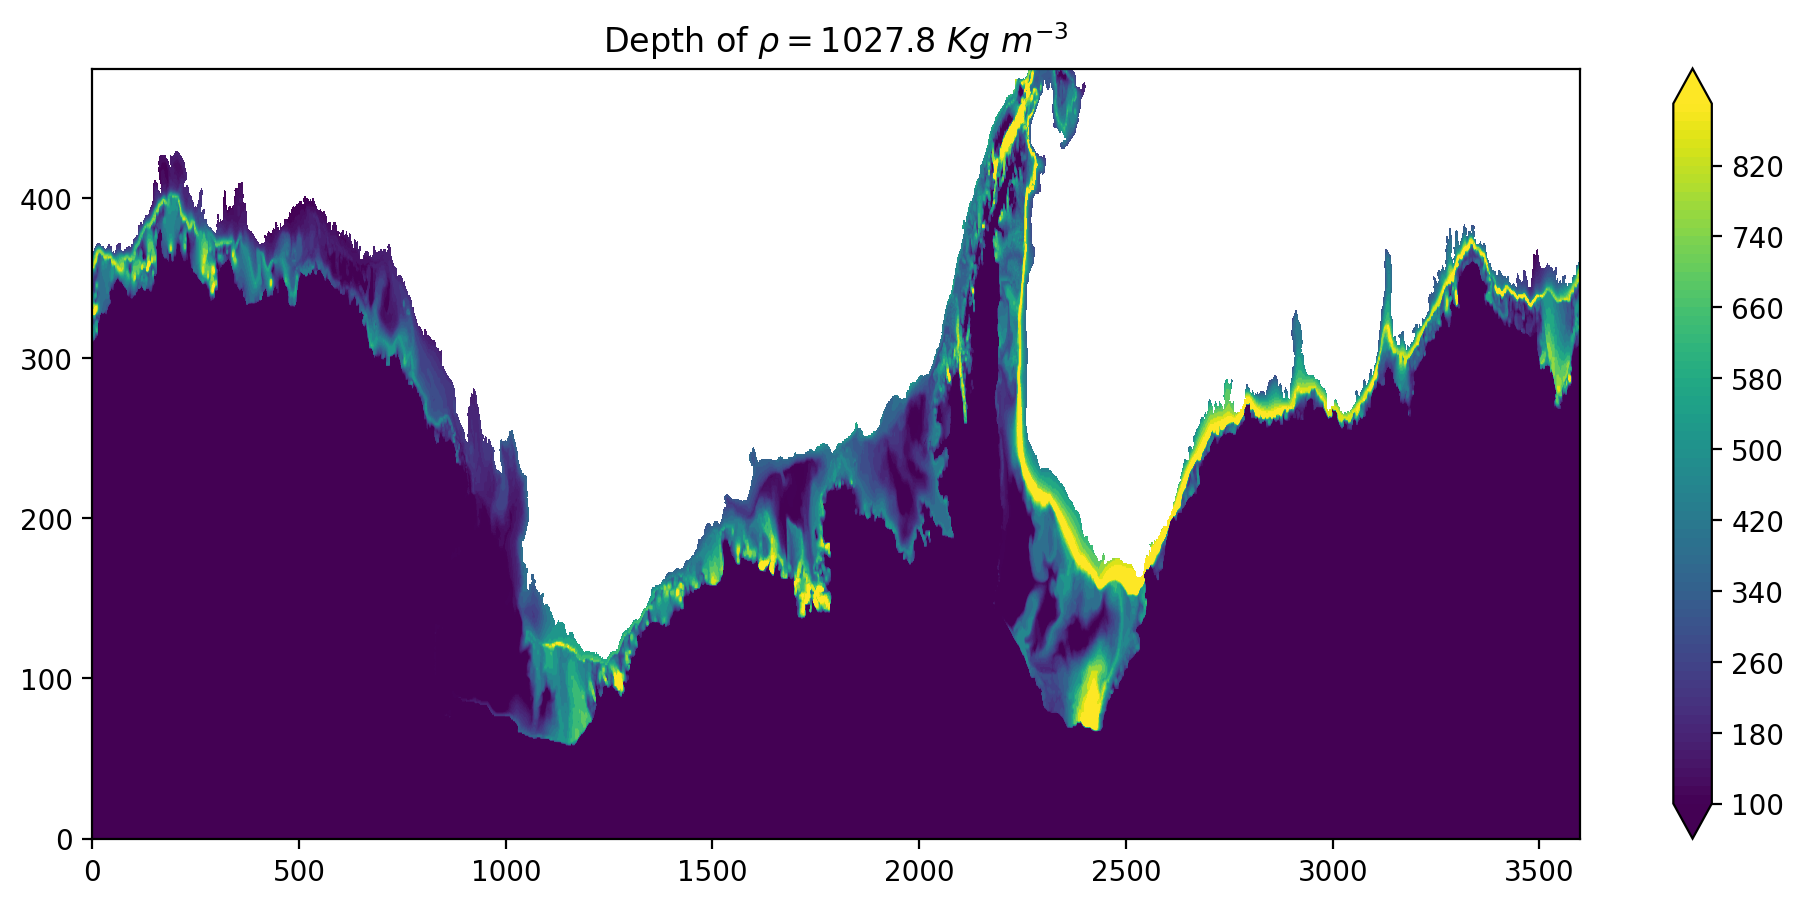

In [381]:
#THis is the depth of the model closet to the 1027.8 kg m-3 isopycnal
figure = plt.figure(num=1, figsize = (12,5))
plt.contourf(Z278_masked.depth,np.arange(100,900,10),extend='both')
plt.colorbar()
plt.title(r"Depth of $\rho=1027.8\ Kg\ m^{-3}$")

**FOR SOME REASON THE DELTAZS ANDINDEXES ARE ALL WRONG, AND I CANT FIGURE OUT WHY NOW. I WILL HAVE TO PAUSE THIS FOR NOW, BUT WILL TRY TO SOVE IT AGAIN NEXT WEEK**

What about using the speeds between the 800 and 1000 m isobaths - Figure out which isobaths best isolate the ASC -  Talk to wilma about it

Taimoor
Ellie 
Fabio
Wilma
Paul
Adele
Wilton


Check the heat transport in different depth slices, instead of fully integrated. 

In [382]:
#Distance along latitudes
from geopy.distance import geodesic as GD
lat_along_contour2=pot_rho_0['yt_ocean']
lon_along_contour2=np.zeros(np.shape(pot_rho_0['yt_ocean']))


meridional_distances = GD((lat_along_contour2[0],lon_along_contour2[0]) ,(lat_along_contour2[1],lon_along_contour2[1])).km
meridional_distances= np.tile(meridional_distances,(481)).T 
deltaS3 = np.tile(meridional_distances,(3600,1)).T 
np.shape(deltaS3 )

(481, 3600)

2023-05-09 15:45:52,513 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:52,802 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:52,832 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:53,063 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:53,612 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:53,819 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:53,825 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:54,335 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:54,340 - distributed.nanny - WARNING - Restarting worker
2023-05-09 15:45:54,499 - distributed.nanny - WARNING - Restarting worker


In [332]:
#calculating deltaZ/DeltaS
deltaS=np.diff(pot_rho_0['yt_ocean'].isel(yt_ocean=slice(0,481)),n=0)
deltaS2 = np.tile(deltaS,(3600,1)).T 
#deltaZ=np.diff(Z278_masked,n=2,axis=0)
deltaZ=np.diff(Z278_masked.depth,axis=0)
#deltaZ = np.ma.masked_where(deltaZ>=1000,deltaZ,np.NaN)
#deltaZ = np.ma.masked_where(deltaZ<=-1000,deltaZ,np.NaN)
#deltaZ = np.ma.masked_where(deltaZ==0,deltaZ,np.NaN)
dzds=deltaZ/deltaS3

In [368]:
#MAsking dzds
dzds_ = dzds + pot_rho_0.isel(st_ocean=0,yt_ocean=slice(0,481)) - pot_rho_0.isel(st_ocean=0,yt_ocean=slice(0,481))

Text(0.5, 1.0, '$ \\frac{\\delta Z}{\\delta S^{j}} [\\frac{m}{km}]$ for $\\rho _{0} = 1027.8\\ Kg\\ m^{-3}$  - Climatology [RYF]')

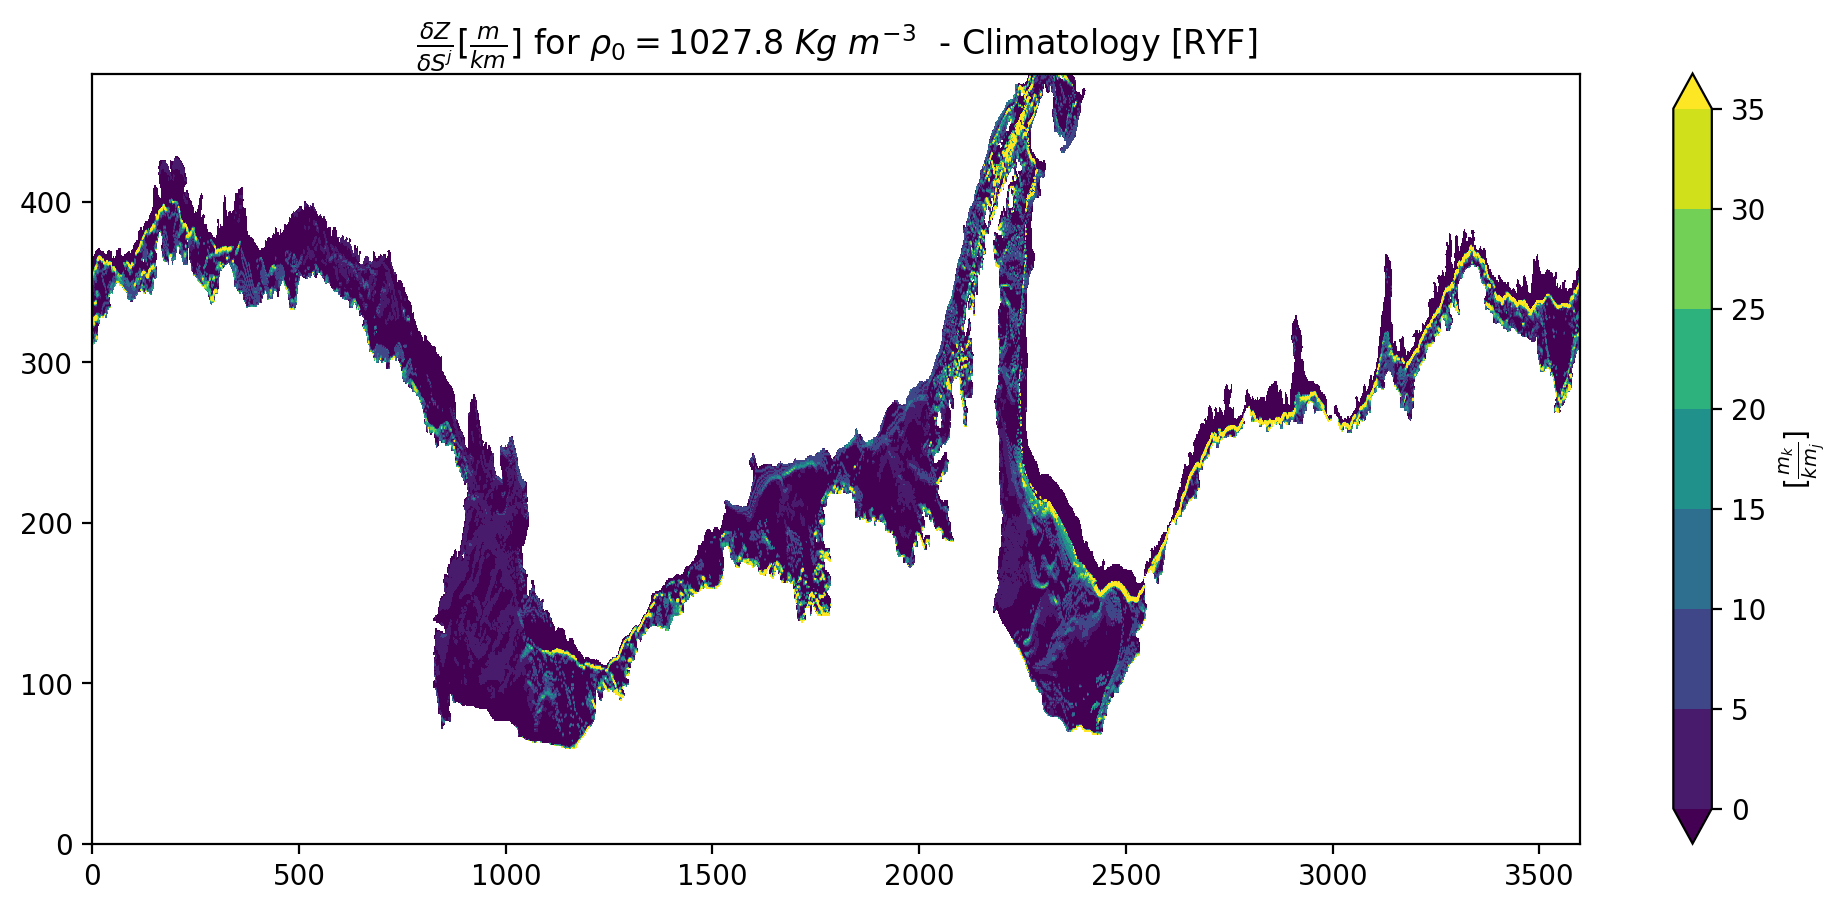

In [378]:
figure = plt.figure(num=1, figsize = (12,5))
plt.contourf(dzds_,np.arange(0,40,5),extend='both')
plt.colorbar(label=r"$[\frac{m_{k}}{km_{j}}]$")
plt.title(r"$ \frac{\delta Z}{\delta S^{j}} [\frac{m}{km}]$ for $\rho _{0} = 1027.8\ Kg\ m^{-3}$  - Climatology [RYF]")

In [113]:
deltaZmaxind = np.nanargmax(deltaZ,axis=0) #index along latitudes
deltaZmax = np.nanmax(deltaZ,axis=0)
ytocean=pot_rho_0['yt_ocean']
# deltaZmax = deltaZ[deltaZmaxind]

(1038674,)

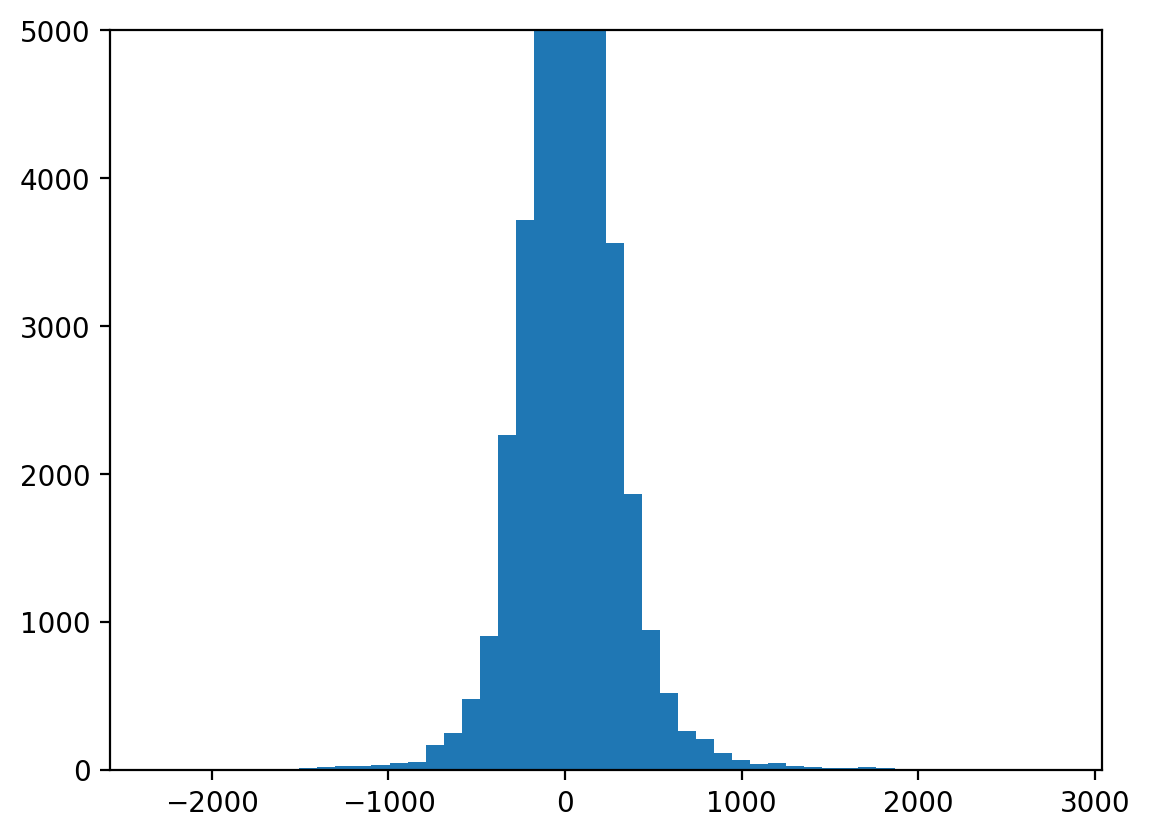

In [116]:
# CHecking an histogram - why do we have values above 1000, when maximum dzt is ~250 for the grid?
nonandz = deltaZ[~np.isnan(deltaZ)]
nonandz = nonandz[nonandz!=0]

pylab.figure()
pylab.hist(nonandz,bins=50)
plt.ylim(0,5000)
#histogram = np.histogram(isnumeric(Z278_masked),bins=20)
#plt.plot(histogram[0],histogram[1])

In [121]:
range(3600)

range(0, 3600)

In [131]:
xt_ocean=pot_rho_0['xt_ocean']

427

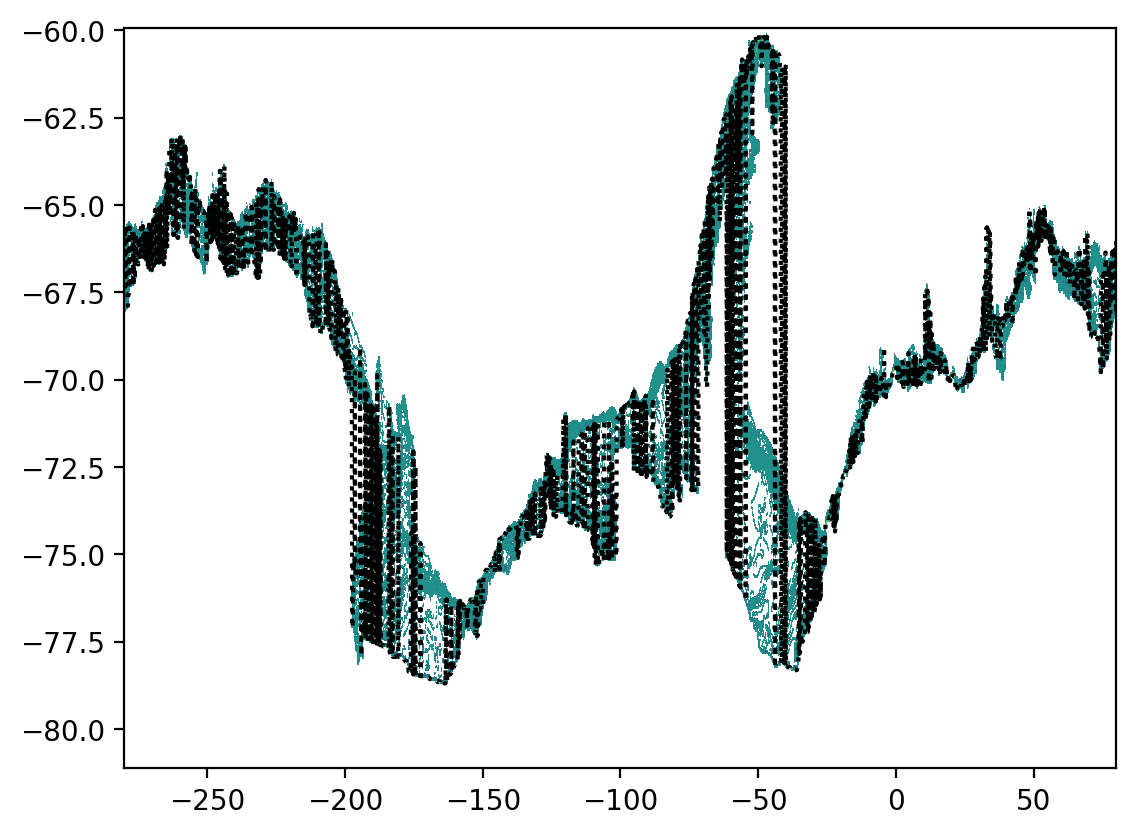

In [138]:
plt.contourf(xt_ocean,yt_ocean[:492],deltaZ)
plt.plot(xt_ocean,yt_ocean[np.array(deltaZmaxind)],':k')
#plt.colorbar()

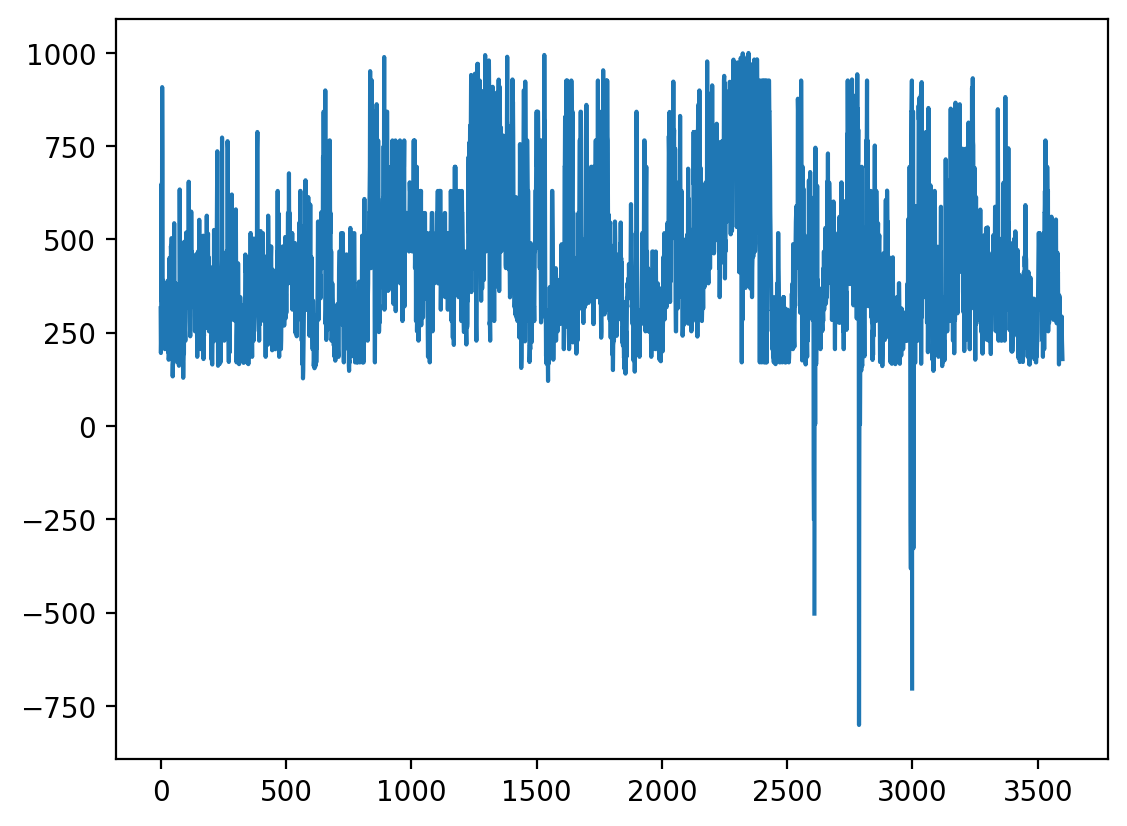

In [64]:
plt.plot(deltaZmax)
